## Monte Carlo Value Prediction Algorithm for Estimation 

Resources used while writing this notebook:
- [Nimish Sanghi's book on Deep RL](https://www.amazon.com/Deep-Reinforcement-Learning-Python-TensorFlow/dp/1484268083)
- [University of Alberta's RL specialization](https://www.coursera.org/specializations/reinforcement-learning)

Note: Sanghi's book creates a custom environment called Gridworld to try its algorithms on. However, that environment is based on OpenAI's Gym library and has been deprecated,ie, we cannot use it anymore :(. But nothing to worry about, as we will try our algorithms on the Blackjack environment of the Gymnasium library.

&nbsp;

This is an on-policy algorithm.

![First-visit MC Prediction](./algo_img/first_visit_mc_prediction.png "First-visit MC Prediction")

![Every-visit MC Prediction](./algo_img/every_visit_on-policy_mc_control.png "Every-visit MC Prediction")

In [1]:
from IPython.display import Image
Image(url="https://gymnasium.farama.org/_images/blackjack.gif")

In [1]:
import gymnasium as gym
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
from blackjack.plot_utils import plot_policy, plot_win_rate

# create Blackjack environment
env = gym.make("Blackjack-v1", natural=False, sab=False)

In [14]:
def fn():
    n_actions = env.action_space.n
    random_policy = defaultdict(lambda: np.ones(n_actions) / n_actions)
    state = (19, 10, False)
    random_policy[state]
    print(random_policy)
    print(np.argmax(random_policy[state]))
    

fn()

defaultdict(<function fn.<locals>.<lambda> at 0x7f4256e8d790>, {(19, 10, False): array([0.5, 0.5])})
0


In [35]:
def epsilon_greedy_strategy(env, epsilon, policy, state):
    if np.random.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(policy[state])
    

In [7]:
def fn():
    V = defaultdict(float)
    V[(1,2,3)] = 5.46
    V[(4,5,6)] = 7.13
    return V

fn()

defaultdict(float, {(1, 2, 3): 5.46, (4, 5, 6): 7.13})

In [82]:
class MC_Prediction:
    def __init__(self, num_episodes, env, gamma, policy, epsilon, 
                 strategy, alpha=None):
        self.num_episodes = num_episodes
        self.env = env
        self.V = defaultdict(float)   # estimated state values
        self.N = defaultdict(int)     # visit count
        self.policy = policy
        self.gamma = gamma            # discount factor
        self.epsilon = epsilon        # exploration rate
        self.strategy = strategy      # action selection strategy
        self.alpha = alpha            # constant factor
        self.rewards_all_episodes_fv = []
        self.rewards_all_episodes_ev = []

    def generate_episode(self):
        state, _ = self.env.reset()
        episode = []
        while True:
            action = self.strategy(self.env, self.epsilon, 
                                   self.policy, state)
            next_state, reward, done, trunc, _ = env.step(action)
            episode.append((state, reward))
            state = next_state
            if (done or trunc):
                break
        return episode


    def first_visit(self):
        """
        This is the first-visit MC Value Prediction algorithm for estimation.
        Check pg. 80 of Nimish Sanghi's book for the pseudocode.
        """
        for _ in tqdm(range(self.num_episodes)):
            experience = self.generate_episode()
            states, rewards = zip(*experience)
            self.rewards_all_episodes_fv.append(sum(rewards))
            G = 0
            for t in range(len(states)-1, -1, -1):
                s, r = states[t], rewards[t]
                G = self.gamma * G + r
                if s not in states[:t]:
                    if self.alpha is not None:
                        self.V[s] = self.V[s] + self.alpha * (G - self.V[s])
                    else:
                        self.N[s] += 1
                        self.V[s] = self.V[s] + (1/self.N[s]) * (G - self.V[s])
        return self.V


    def every_visit(self):
        """
        This is the every-visit MC Value Prediction algorithm for estimation.
        """
        for _ in tqdm(range(self.num_episodes)):
            experience = self.generate_episode()
            states, rewards = zip(*experience)
            self.rewards_all_episodes_ev.append(sum(rewards))
            G = 0
            for t in range(len(states)-1, -1, -1):
                s, r = states[t], rewards[t]
                G = self.gamma * G + r
                if self.alpha is not None:
                    self.V[s] = self.V[s] + self.alpha * (G - self.V[s])
                else:
                    self.N[s] += 1
                    self.V[s] = self.V[s] + (1/self.N[s]) * (G - self.V[s])
        return self.V
    

In [74]:
n_actions = env.action_space.n
random_policy = defaultdict(lambda: np.ones(n_actions) / n_actions)
num_episodes = 10_000
env = gym.make("Blackjack-v1", natural=False, sab=False)
gamma = 1
epsilon = 1
strategy = epsilon_greedy_strategy

In [75]:
fv_mc = MC_Prediction(num_episodes, env, gamma, random_policy, epsilon, strategy)

In [76]:
fv_mc.generate_episode()

[((8, 4, 0), -1.0)]

In [77]:
fv_mc.first_visit()

100%|██████████| 10000/10000 [00:01<00:00, 5616.39it/s]


defaultdict(float,
            {(18, 4, 0): -0.15,
             (17, 10, 0): -0.6138613861386139,
             (15, 10, 0): -0.6282894736842105,
             (18, 5, 1): -0.3125,
             (7, 5, 0): 0.0,
             (15, 5, 0): -0.34210526315789475,
             (14, 10, 0): -0.6095238095238096,
             (7, 10, 0): -0.5,
             (19, 7, 1): 0.4,
             (8, 7, 0): -0.16666666666666666,
             (5, 7, 0): -0.6666666666666666,
             (18, 9, 0): -0.5357142857142857,
             (13, 10, 0): -0.5778546712802768,
             (18, 10, 0): -0.5427509293680297,
             (16, 10, 0): -0.6013289036544851,
             (10, 10, 0): -0.3971631205673759,
             (11, 10, 0): -0.6125,
             (15, 10, 1): -0.7297297297297297,
             (19, 10, 0): -0.40217391304347827,
             (12, 10, 0): -0.5474006116207951,
             (9, 9, 0): -0.5,
             (15, 1, 0): -0.927710843373494,
             (19, 1, 0): -0.4461538461538462,
             (

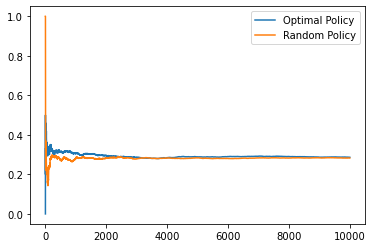

In [80]:
plot_win_rate(fv_mc.rewards_all_episodes_fv, fv_mc.num_episodes)

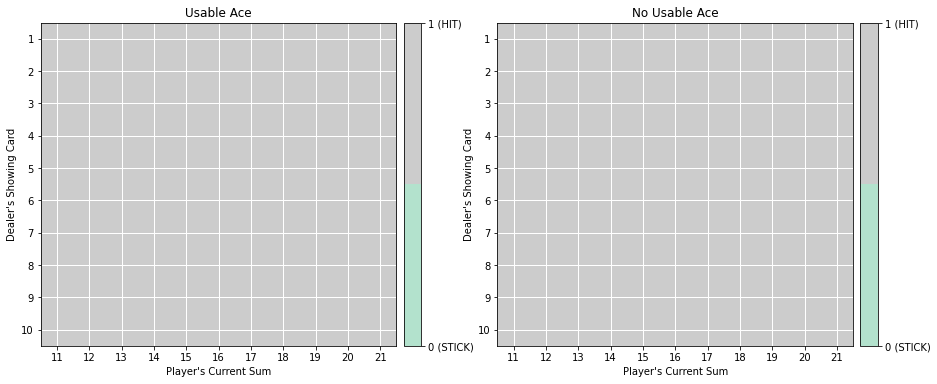

In [81]:
# the plots are empty as we don't have a policy, ie,
# we are following a random policy
plot_policy(fv_mc.policy)

![Optimal Policy](./blackjack/optimal.png "Optimal Policy")